In [1]:
import os
from tqdm import tnrange, tqdm_notebook, tqdm
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from torchvision.utils import save_image, make_grid
from torch.autograd import Variable
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tensorboardX import SummaryWriter

In [2]:
# os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [3]:
from matplotlib import rcParams
rcParams['figure.figsize'] = (12, 8)

%matplotlib inline

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
torch.cuda.is_available()

True

In [6]:
device_ids = [0]

In [7]:
batch_size = 128
num_epochs = 30

z_dimension = 100
num_feature = (32, 4, 4) # 64 * 64

img_shape = (1, 32, 32)

In [8]:
img_transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize((.5, .5, .5), (.5, .5, .5))
])

dataset = datasets.MNIST('/home/left5/datas/mnist', transform=img_transform) #, download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

In [9]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.label_embedding = nn.Embedding(10, np.prod(img_shape))
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(2, 16, 3, padding=1, stride=2),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(.2, True),
#             nn.AvgPool2d(2, 2), 
        ) # b 16 16 16
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 3, padding=1, stride=2),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(.2, True),
#             nn.AvgPool2d(2, 2), 
        ) # b 32 8 8
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1, stride=2),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(.2, True),
#             nn.AvgPool2d(2, 2), 
        ) # b 64 4 4
        
        self.conv4 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1, stride=2),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(.2, True),
#             nn.AvgPool2d(2, 2), 
        ) # b 128 2 2
        
        self.fc = nn.Sequential(
            nn.Linear(128 * 2 * 2, 1024),
            nn.LeakyReLU(.2, True),
            nn.Linear(1024, 1),
            nn.Sigmoid(),
        ) # b 1
        
        self.label = nn.Sequential(
            nn.Linear(128 * 2 * 2, 10),
            nn.Sigmoid()
        )

    def forward(self, imgs, labels): # b 1 32 32
        
        _imgs = torch.cat((imgs, self.label_embedding(labels).reshape(imgs.size(0), *img_shape)), 1)

        outs = self.conv1(_imgs)
        outs = self.conv2(outs)
        outs = self.conv3(outs)
        outs = self.conv4(outs)
        outs = outs.view(imgs.size(0), -1)
        img = self.fc(outs)
        lab = self.label(outs)
        
        return img, lab # b 1 1 1, b 10

In [10]:
class Generator(nn.Module):
    def __init__(self, inp_dim, num_feature):
        super(Generator, self).__init__()

        self.label_emb = nn.Embedding(10, 10)
        
        self.fc = nn.Sequential(
            nn.Linear(inp_dim, np.prod(num_feature)),
#             nn.Sigmoid(),
        ) # b *num_feature  b 32 4 4
        
        self.upsample1 = nn.Sequential(
#             nn.BatchNorm2d(128),
            nn.ConvTranspose2d(32, 16, 4, 2, 1),
#             nn.functional.interpolate(scale_factor=2),
#             nn.Upsample(scale_factor=2),
#             nn.Conv2d(32, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(.2, True),
#             nn.ReLU(True),
        ) # b 16 8 8
        
        self.upsample2 = nn.Sequential(
#             nn.functional.interpolate(scale_factor=2),
            nn.ConvTranspose2d(16, 8, 4, 2, 1),
#             nn.Upsample(scale_factor=2),
#             nn.Conv2d(16, 8, 3, padding=1),
            nn.BatchNorm2d(8),
            nn.LeakyReLU(.2, True),
#             nn.ReLU(True),
        ) # b 8 16 16
        
        self.upsample3 = nn.Sequential(
            nn.ConvTranspose2d(8, 4, 4, 2, 1),
#             nn.functional.interpolate(scale_factor=2),
#             nn.Upsample(scale_factor=2),
#             nn.Conv2d(8, 4, 3, padding=1, stride=1),
            nn.BatchNorm2d(4),
            nn.LeakyReLU(.2, True),
#             nn.ReLU(True),
        ) # b 4 32 32
        
        self.conv = nn.Sequential(
#             nn.functional.interpolate(scale_factor=2),
            nn.Conv2d(4, 1, 3, padding=1, stride=1),
            nn.Tanh(),
        ) # b 1 32 32

    def forward(self, noise, labels):
        
#         gen_input = torch.cat((labels.reshape(noise.size(0), -1), noise), -1)
        gen_input = torch.cat((self.label_emb(labels), noise), -1)
        
        outs = self.fc(gen_input)
        outs = outs.view(noise.size(0), *num_feature)
        outs = self.upsample1(outs)
        outs = self.upsample2(outs)
        outs = self.upsample3(outs)
        
        outs = self.conv(outs)
        
        return outs


In [11]:
D = Discriminator().to(device)
G = Generator(z_dimension + 10, num_feature).to(device)

D = nn.DataParallel(D, device_ids=device_ids).to(device)
G = nn.DataParallel(G, device_ids=device_ids).to(device)

adversarial_loss = nn.MSELoss()
auxiliary_loss = torch.nn.CrossEntropyLoss()

D_optimezer = optim.Adam(D.parameters(), lr=2e-4, betas=(0, 0.9))
G_optimezer = optim.Adam(G.parameters(), lr=2e-4, betas=(0, 0.9))

In [12]:
condition = torch.from_numpy(np.arange(10)).cuda()

In [13]:
writer = SummaryWriter('./log/cnn_cgan')

In [14]:
img_path = "save_images/cnn_cgan"
if not os.path.exists(img_path): os.makedirs(img_path)

In [15]:
total_count = len(dataloader)
for epoch in tqdm_notebook(range(num_epochs)):
    _step = epoch * total_count
    
    d_loss_total = .0
    g_loss_total = .0
    for i, (imgs, labels) in enumerate(dataloader):
        
        real_imgs = imgs.cuda()
        real_labels = labels.cuda()
        
        real = torch.ones(imgs.size(0), 1).cuda()
        fake = torch.zeros(imgs.size(0), 1).cuda()
        
        z = torch.randn(imgs.size(0), z_dimension).cuda()
        fake_labels = torch.from_numpy(np.random.randint(0, 10, imgs.size(0))).cuda()
        
        ########## G ##########
        fake_imgs = G(z, fake_labels)
        fake_out, fake_out_labels = D(fake_imgs, fake_labels)
        g_loss = adversarial_loss(fake_out, real)
        
        G_optimezer.zero_grad()
        g_loss.backward()
        G_optimezer.step()
        #######################
        
        ########## D ##########
        real_out, real_out_label = D(real_imgs, real_labels)
        d_loss_real = adversarial_loss(real_out, real_labels.float())
#         d_loss_real_label = auxiliary_loss(real_out_label, real_labels)
        real_scores = real_out
        
        fake_out, fake_out_labels = D(fake_imgs.detach(), fake_labels)
        d_loss_fake = adversarial_loss(fake_out, fake)
        fake_scores = fake_out
        
        d_loss = (d_loss_real + d_loss_fake) / 2 # + d_loss_real_label
        D_optimezer.zero_grad()
        d_loss.backward()
        D_optimezer.step()
        #######################
        
        d_loss_total += d_loss.item() * imgs.size(0)
        g_loss_total += g_loss.item() * imgs.size(0)
        
        step = _step + i + 1
        
        if (i + 1) % 100 == 0:
            writer.add_scalar('Discriminator Real Loss', d_loss_real.item(), step)
            writer.add_scalar('Discriminator Fake Loss', d_loss_fake.item(), step)
            writer.add_scalar('Discriminator Loss', d_loss.item(), step)
            writer.add_scalar('Generator Loss', g_loss.item(), step)
        
        if (i + 1) % 300 == 0:
            tqdm.write('Epoch [{}/{}], Step: {:6d}, d_loss: {:.6f}, g_loss: {:.6f}, real_scores: {:.6f}' \
', fake_scores: {:.6f}'.format(epoch+1, num_epochs, (i+1) * batch_size, d_loss, g_loss, real_scores.mean(), fake_scores.mean()))
    
    setp = (epoch + 1) * total_count
    _d_loss_total = d_loss_total / (total_count * (epoch + 1))
    _g_loss_total = g_loss_total / (total_count * (epoch + 1))
    
    writer.add_scalar('Discriminator Total Loss', _d_loss_total, step)
    writer.add_scalar('Generator Total Loss', _g_loss_total, step)
    
    tqdm.write("Finish Epoch [{}/{}], D Loss: {:.6f}, G Loss: {:.6f}".format(epoch+1, 
                                                                             num_epochs, 
                                                                             _d_loss_total,
                                                                             _g_loss_total, ))
    
    if epoch == 0:
        real_images = real_imgs.view(-1, 1, 32, 32).cpu().data
        save_image(real_images, os.path.join(img_path, 'real_images.png'))
        
    noise = torch.randn(10, z_dimension).cuda()
    condition_images = G(noise, condition)
    
    writer.add_image('Generator Image', make_grid(fake_imgs.view(-1, 1, 32, 32).cpu().data, normalize=True, scale_each=True), step)
    writer.add_image('Condition Generator Image', make_grid(condition_images.view(-1, 1, 32, 32).cpu().data, normalize=True, scale_each=True), step)
    
    fake_images = fake_imgs.view(-1, 1, 32, 32).cpu().data
    save_image(fake_images, os.path.join(img_path, 'fake_images-{}.png'.format(epoch+1)))
    save_image(condition_images, os.path.join(img_path, 'condition_images-{}.png'.format(epoch+1)))

Epoch [1/30], Step:  38400, d_loss: 9.700836, g_loss: 0.925431, real_scores: 0.999940, fake_scores: 0.050423
Finish Epoch [1/30], D Loss: 1307.575957, G Loss: 108.921435
Epoch [2/30], Step:  38400, d_loss: 9.869413, g_loss: 0.149900, real_scores: 0.999552, fake_scores: 0.796861
Finish Epoch [2/30], D Loss: 667.709325, G Loss: 25.345365
Epoch [3/30], Step:  38400, d_loss: 8.996090, g_loss: 0.000000, real_scores: 1.000000, fake_scores: 0.999996
Finish Epoch [3/30], D Loss: 453.756656, G Loss: 0.346564
Epoch [4/30], Step:  38400, d_loss: 10.941385, g_loss: 0.000000, real_scores: 1.000000, fake_scores: 0.999979
Finish Epoch [4/30], D Loss: 340.231746, G Loss: 0.786314
Epoch [5/30], Step:  38400, d_loss: 11.917888, g_loss: 0.000000, real_scores: 0.999999, fake_scores: 0.999915
Finish Epoch [5/30], D Loss: 272.224393, G Loss: 0.217321
Epoch [6/30], Step:  38400, d_loss: 10.166119, g_loss: 0.004852, real_scores: 0.997653, fake_scores: 0.979546
Finish Epoch [6/30], D Loss: 226.762099, G Loss: 

In [46]:
writer.close()

In [47]:
torch.save(D.state_dict(), './ser/cgan_discriminator.pt')
torch.save(G.state_dict(), './ser/cgan_generator.pt')

In [12]:
D.load_state_dict(torch.load('./ser/cgan_discriminator.pt'))
G.load_state_dict(torch.load('./ser/cgan_generator.pt'))

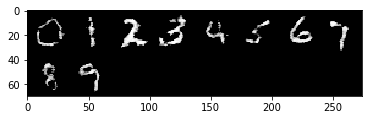

In [18]:
words = np.arange(10)
l = torch.from_numpy(words).cuda()
z = torch.randn(words.size, z_dimension).to(device)
images = G(z, l)
# save_image(images, 'xx.png')
plt.imshow(Image.fromarray(make_grid(images).mul(255).clamp(0, 255).byte().permute(1, 2, 0).cpu().numpy()))
plt.show()